## Import 

In [ ]:
import numpy as np  # Importing NumPy for numerical operations on arrays
import matplotlib.pyplot as plt  # Importing Matplotlib for plotting images
import os  # Importing OS for file and directory operations
from patchify import patchify, unpatchify  # Importing patchify for splitting and reconstructing images
import random  # Importing random for random operations
from PIL import Image  # Importing PIL for image processing
from datasets import Dataset  # Importing Huggingface's Dataset class for handling data
from torch.utils.data import Dataset  # Import the Dataset class from PyTorch
from torch.utils.data import DataLoader

from torch.optim import Adam
import monai

from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize




#### Function to load and pad images from a folder to a target size
 

In [ ]:
def load_and_pad_images_from_folder(folder, target_size=(1024, 1536)):
    images = []  # List to store images
    filenames = []  # List to store filenames
    for filename in sorted(os.listdir(folder)):  # Iterate over sorted filenames in the folder
        img_path = os.path.join(folder, filename)  # Construct the full image path
        if os.path.isfile(img_path):  # Check if it is a file
            img = Image.open(img_path).convert('RGB')  # Open the image and convert to RGB
            img_array = np.array(img)  # Convert the image to a NumPy array
            # Pad the image to the target size
            pad_width = ((0, 0), (0, target_size[1] - img_array.shape[1]), (0, 0))
            padded_img = np.pad(img_array, pad_width, mode='constant', constant_values=0)
            images.append(padded_img)  # Append padded image to the list
            filenames.append(filename)  # Append filename to the list
    return np.array(images), filenames  # Return images and filenames as NumPy arrays


###  Function to load and pad masks from a folder to a target size


In [ ]:
def load_and_pad_masks_from_folder(folder, target_size=(1024, 1536)):
    masks = []  # List to store masks
    filenames = []  # List to store filenames
    for filename in sorted(os.listdir(folder)):  # Iterate over sorted filenames in the folder
        mask_path = os.path.join(folder, filename)  # Construct the full mask path
        if os.path.isfile(mask_path):  # Check if it is a file
            mask = np.load(mask_path)  # Load the mask file (NumPy array)
            # Pad the mask to the target size
            pad_width = ((0, 0), (0, target_size[1] - mask.shape[1]))
            padded_mask = np.pad(mask, pad_width, mode='constant', constant_values=0)
            masks.append(padded_mask)  # Append padded mask to the list
            filenames.append(filename)  # Append filename to the list
    return np.array(masks), filenames  # Return masks and filenames as NumPy arrays


In [ ]:
# Folder paths
image_folder_path = r'/data1/sprasad/baseline/image3 2/image3'
mask_folder_path = r'/data1/sprasad/data/train/label3'

# Load and pad images and masks
large_images, image_filenames = load_and_pad_images_from_folder(image_folder_path)
large_masks, mask_filenames = load_and_pad_masks_from_folder(mask_folder_path)

# Ensure the filenames are sorted and correspond
image_filenames = sorted(image_filenames)
mask_filenames = sorted(mask_filenames)

# Print shapes
print(f'Shape of large_images: {large_images.shape}')  # Should be (18, 1024, 1536, 3)
print(f'Shape of large_masks: {large_masks.shape}')    # Should be (18, 1024, 1536)


In [ ]:
# Desired patch size for smaller images and step size.
patch_size = 256
step = 256
all_img_patches = []  # List to store image patches
all_mask_patches = []  # List to store mask patches
all_patch_filenames = []  # List to store patch filenames



# Iterate over each large image and mask
for img_idx in range(large_images.shape[0]):
    large_image = large_images[img_idx]  # Select the current large image
    patches_img = patchify(large_image, (patch_size, patch_size, 3), step=step)  # Create patches from the image

    large_mask = large_masks[img_idx]  # Select the current large mask
    patches_mask = patchify(large_mask, (patch_size, patch_size), step=step)  # Create patches from the mask

    # Iterate over each patch in the image and mask
    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):
            single_patch_img = patches_img[i, j, :, :, :]  # Extract a single image patch
            single_patch_mask = patches_mask[i, j, :, :]  # Extract a single mask patch

            all_img_patches.append(single_patch_img)  # Append image patch to the list
            all_mask_patches.append(single_patch_mask)  # Append mask patch to the list

            # Generate a patch filename for tracking
            patch_filename = f"{image_filenames[img_idx].split('.')[0]}_patch_{i}_{j}.npy"
            all_patch_filenames.append(patch_filename)  # Append patch filename to the list


images = np.array(all_img_patches)  # Convert image patches list to a NumPy array
masks = np.array(all_mask_patches)  # Convert mask patches list to a NumPy array

# Create a list to store the indices of non-empty masks
valid_indices = [i for i, mask in enumerate(masks) if mask.max() != 0]


# Filter the image and mask arrays to keep only the non-empty pairs
filtered_images = images[valid_indices]
filtered_masks = masks[valid_indices]
filtered_filenames = [all_patch_filenames[i] for i in valid_indices]


# Print shapes of the filtered images and masks
print("Image shape:", filtered_images.shape)  # e.g., (num_patches, height, width, num_channels)
print("Mask shape:", filtered_masks.shape)  # e.g., (num_patches, height, width)



# Remove the extra dimension from images
filtered_images = np.squeeze(filtered_images, axis=1)
filtered_images = filtered_images.astype(np.uint8)  # Convert images to unsigned 8-bit integer type
filtered_masks = filtered_masks.astype(np.uint8)  # Convert masks to unsigned 8-bit integer type




### Convert the NumPy arrays to Pillow images and store them in a dictionary

In [ ]:


dataset_dict = {
    "image": [Image.fromarray(img) for img in filtered_images],
    "label": [Image.fromarray(mask) for mask in filtered_masks],
    "filename": filtered_filenames
}


# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)



### Randomly select an image-mask pair to display

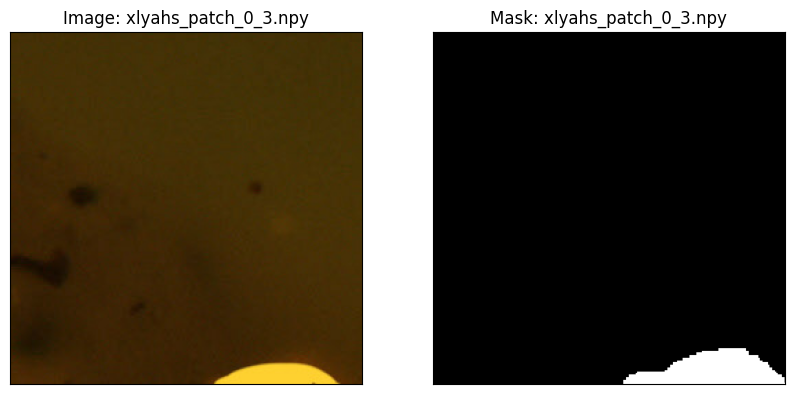

In [2]:
img_num = random.randint(0, filtered_images.shape[0] - 1)  # Select a random index within the range of the filtered images array
example_image = dataset[img_num]["image"]  # Retrieve the image corresponding to the random index from the dataset
example_mask = dataset[img_num]["label"]  # Retrieve the mask corresponding to the random index from the dataset
example_filename = dataset[img_num]["filename"]  # Retrieve the filename corresponding to the random index from the dataset

fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # Create a figure with 1 row and 2 columns, setting the figure size to 10x5 inches

# Plot the first image on the left
axes[0].imshow(np.array(example_image))  # Convert the PIL image to a NumPy array and display it in RGB
axes[0].set_title(f"Image: {example_filename}")  # Set the title of the first subplot to the image filename

# Plot the second image on the right
axes[1].imshow(np.array(example_mask), cmap='gray')  # Convert the mask to a NumPy array and display it in grayscale
axes[1].set_title(f"Mask: {example_filename}")  # Set the title of the second subplot to the mask filename

# Hide axis ticks and labels for both subplots
for ax in axes:
    ax.set_xticks([])  # Remove x-axis ticks
    ax.set_yticks([])  # Remove y-axis ticks
    ax.set_xticklabels([])  # Remove x-axis tick labels
    ax.set_yticklabels([])  # Remove y-axis tick labels

# Display the images side by side
plt.show()  # Render the figure


### Get bounding boxes from mask.

In [3]:
'''
This function computes the bounding box of
non-zero regions in a given mask (binary image).
It also adds random perturbations to the bounding box coordinates.

'''


def get_bounding_box(ground_truth_map):  # Define a function to get the bounding box from a mask
    # get bounding box from mask
    y_indices, x_indices = np.where(ground_truth_map > 0)  # Find indices of non-zero elements in the mask
    x_min, x_max = np.min(x_indices), np.max(x_indices)  # Get minimum and maximum x-coordinates of the bounding box
    y_min, y_max = np.min(y_indices), np.max(y_indices)  # Get minimum and maximum y-coordinates of the bounding box
    
    # add perturbation to bounding box coordinates
    H, W = ground_truth_map.shape  # Get the height and width of the mask
    x_min = max(0, x_min - np.random.randint(0, 20))  # Subtract a random value between 0 and 19 from x_min, ensuring it's non-negative
    x_max = min(W, x_max + np.random.randint(0, 20))  # Add a random value between 0 and 19 to x_max, ensuring it doesn't exceed the width
    y_min = max(0, y_min - np.random.randint(0, 20))  # Subtract a random value between 0 and 19 from y_min, ensuring it's non-negative
    y_max = min(H, y_max + np.random.randint(0, 20))  # Add a random value between 0 and 19 to y_max, ensuring it doesn't exceed the height
    
    bbox = [x_min, y_min, x_max, y_max]  # Create a list representing the bounding box coordinates

    return bbox  # Return the bounding box coordinates


### SAM DATASET

In [4]:
class SAMDataset(Dataset):
    """
    This class is used to create a dataset that serves input images and masks.
    It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
    """
    def __init__(self, dataset, processor):  # Initialize the dataset and processor
        self.dataset = dataset  # Store the dataset
        self.processor = processor  # Store the processor

    def __len__(self):  # Return the length of the dataset
        return len(self.dataset)

    def __getitem__(self, idx):  # Get an item from the dataset by index
        item = self.dataset[idx]  # Retrieve the item from the dataset
        image = item["image"]  # Extract the image from the item
        ground_truth_mask = np.array(item["label"])  # Extract the mask and convert it to a NumPy array

        # get bounding box prompt
        prompt = get_bounding_box(ground_truth_mask)  # Generate the bounding box from the mask

        # prepare image and prompt for the model
        inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")  # Process the image and bounding box to prepare for the model

        # remove batch dimension which the processor adds by default
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}  # Remove the batch dimension from the processed inputs

        # add ground truth segmentation
        inputs["ground_truth_mask"] = ground_truth_mask  # Add the ground truth mask to the inputs

        return inputs  # Return the processed inputs


### Initialize the processor

In [5]:
'''
This line initializes a processor using a pre-trained model from the Huggingface Transformers library. 
The processor is used for preparing images and bounding boxes for the model.


'''
from transformers import SamProcessor  # Import the SamProcessor class from the Huggingface Transformers library

processor = SamProcessor.from_pretrained("facebook/sam-vit-base")  # Initialize the processor with a pre-trained model


2024-06-17 14:34:55.161815: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-17 14:34:55.973137: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Create an instance of the SAMDataset

In [7]:
# Create an instance of the SAMDataset
train_dataset = SAMDataset(dataset=dataset, processor=processor)  # Initialize the SAMDataset with the dataset and processor

example = train_dataset[0]  # Retrieve the first example from the dataset

for k, v in example.items():  # Iterate through each item in the example
    print(k, v.shape)  # Print the key and shape of each item


pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (256, 256)


### Create a DataLoader instance for the training dataset

In [9]:

from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=False)

batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 256, 256])


In [10]:
batch["ground_truth_mask"].shape

torch.Size([2, 256, 256])

### Load the model

In [11]:
# Load the model
from transformers import SamModel  # Import the SamModel class from the Huggingface Transformers library
model = SamModel.from_pretrained("facebook/sam-vit-base")  # Initialize the model with a pre-trained version of "sam-vit-base"

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():  # Iterate through the named parameters of the model
    if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):  # Check if the parameter belongs to the vision encoder or prompt encoder
        param.requires_grad_(False)  # Freeze the parameter by setting requires_grad to False


In [12]:
'''
This code snippet initializes an optimizer and a loss function for training the model.
The optimizer will update the parameters of the mask decoder during training,
and the loss function will evaluate the performance of the model's predictions

'''



# Initialize the optimizer and the loss function
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)  # Initialize the Adam optimizer for the mask decoder parameters with a learning rate of 1e-5 and no weight decay

# Try DiceFocalLoss, FocalLoss, DiceCELoss
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')  # Initialize the DiceCELoss loss function with specific options


In [13]:
'''

This code snippet sets up a directory to save model weights,
defines a training loop for a specified number of epochs,
and trains the model while saving the weights after each epoch.
It also prints the mean loss for each epoch.

'''


# Define the directory to save the model weights
save_dir = '/data1/sprasad/maskingApproach2/vit_model_weights_3_2'  # Define the directory to save the model weights
os.makedirs(save_dir, exist_ok=True)  # Create the directory if it does not exist

# Training loop
num_epochs = 100  # Define the number of epochs for training

device = "cuda" if torch.cuda.is_available() else "cpu"  # Use GPU if available, otherwise use CPU
model.to(device)  # Move the model to the appropriate device (GPU or CPU)

model.train()  # Set the model to training mode
for epoch in range(num_epochs):  # Loop over the number of epochs
    epoch_losses = []  # Initialize a list to store the loss for each batch in the epoch
    for batch in tqdm(train_dataloader):  # Loop over batches in the training dataloader
        # Forward pass
        outputs = model(pixel_values=batch["pixel_values"].to(device),  # Pass pixel values to the model
                        input_boxes=batch["input_boxes"].to(device),  # Pass bounding boxes to the model
                        multimask_output=False)  # Disable multi-mask output

        # Compute loss
        predicted_masks = outputs.pred_masks.squeeze(1)  # Extract predicted masks and remove the extra dimension
        ground_truth_masks = batch["ground_truth_mask"].float().to(device)  # Get ground truth masks and move to the appropriate device
        loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))  # Compute the loss between predicted and ground truth masks

        # Backward pass (compute gradients of parameters w.r.t. loss)
        optimizer.zero_grad()  # Zero the gradients before the backward pass
        loss.backward()  # Compute the gradients

        # Optimize
        optimizer.step()  # Update the model parameters
        epoch_losses.append(loss.item())  # Append the loss for the current batch to the list

    # Save model weights after each epoch
    save_path = os.path.join(save_dir, f'model_epoch_{epoch}.pth')  # Define the save path for the model weights
    torch.save(model.state_dict(), save_path)  # Save the model weights

    print(f'EPOCH: {epoch}')  # Print the current epoch
    print(f'Mean loss: {mean(epoch_losses)}')  # Print the mean loss for the epoch


100%|██████████| 155/155 [00:54<00:00,  2.83it/s]


EPOCH: 0
Mean loss: 0.511850419063722


100%|██████████| 155/155 [00:59<00:00,  2.61it/s]


EPOCH: 1
Mean loss: 0.3771012594142268


100%|██████████| 155/155 [00:57<00:00,  2.68it/s]


EPOCH: 2
Mean loss: 0.3320419861424354


100%|██████████| 155/155 [01:00<00:00,  2.58it/s]


EPOCH: 3
Mean loss: 0.3200416098198583


100%|██████████| 155/155 [00:53<00:00,  2.90it/s]


EPOCH: 4
Mean loss: 0.28867433179290064


100%|██████████| 155/155 [00:54<00:00,  2.86it/s]


EPOCH: 5
Mean loss: 0.28106919901986277


100%|██████████| 155/155 [00:56<00:00,  2.76it/s]


EPOCH: 6
Mean loss: 0.2699643085560491


100%|██████████| 155/155 [00:56<00:00,  2.72it/s]


EPOCH: 7
Mean loss: 0.25990906924970686


100%|██████████| 155/155 [00:52<00:00,  2.95it/s]


EPOCH: 8
Mean loss: 0.2500307845492517


100%|██████████| 155/155 [00:52<00:00,  2.94it/s]


EPOCH: 9
Mean loss: 0.24436438674888303


100%|██████████| 155/155 [00:54<00:00,  2.86it/s]


EPOCH: 10
Mean loss: 0.23883676591419403


100%|██████████| 155/155 [00:57<00:00,  2.70it/s]


EPOCH: 11
Mean loss: 0.23198559267386312


100%|██████████| 155/155 [00:58<00:00,  2.66it/s]


EPOCH: 12
Mean loss: 0.22651311269690913


100%|██████████| 155/155 [00:50<00:00,  3.04it/s]


EPOCH: 13
Mean loss: 0.2309110795778613


100%|██████████| 155/155 [00:52<00:00,  2.95it/s]


EPOCH: 14
Mean loss: 0.22222183043918303


100%|██████████| 155/155 [00:53<00:00,  2.88it/s]


EPOCH: 15
Mean loss: 0.21295391479807516


100%|██████████| 155/155 [00:52<00:00,  2.94it/s]


EPOCH: 16
Mean loss: 0.21169808052720562


100%|██████████| 155/155 [00:54<00:00,  2.85it/s]


EPOCH: 17
Mean loss: 0.20529274009168147


100%|██████████| 155/155 [00:52<00:00,  2.96it/s]


EPOCH: 18
Mean loss: 0.20693904952176156


100%|██████████| 155/155 [00:52<00:00,  2.96it/s]


EPOCH: 19
Mean loss: 0.20583588644381492


100%|██████████| 155/155 [00:52<00:00,  2.96it/s]


EPOCH: 20
Mean loss: 0.20126882517530073


100%|██████████| 155/155 [00:52<00:00,  2.96it/s]


EPOCH: 21
Mean loss: 0.20301093968652908


100%|██████████| 155/155 [00:55<00:00,  2.77it/s]


EPOCH: 22
Mean loss: 0.20492701362217627


100%|██████████| 155/155 [00:55<00:00,  2.79it/s]


EPOCH: 23
Mean loss: 0.1976302555011165


100%|██████████| 155/155 [00:52<00:00,  2.94it/s]


EPOCH: 24
Mean loss: 0.1911826278653837


100%|██████████| 155/155 [00:58<00:00,  2.63it/s]


EPOCH: 25
Mean loss: 0.18619398354522643


100%|██████████| 155/155 [01:00<00:00,  2.56it/s]


EPOCH: 26
Mean loss: 0.18588908929978648


100%|██████████| 155/155 [00:56<00:00,  2.74it/s]


EPOCH: 27
Mean loss: 0.18394555449485778


100%|██████████| 155/155 [01:17<00:00,  1.99it/s]


EPOCH: 28
Mean loss: 0.1828758630300722


100%|██████████| 155/155 [00:57<00:00,  2.70it/s]


EPOCH: 29
Mean loss: 0.17934501560464983


100%|██████████| 155/155 [01:08<00:00,  2.26it/s]


EPOCH: 30
Mean loss: 0.17296431218424152


100%|██████████| 155/155 [00:59<00:00,  2.59it/s]


EPOCH: 31
Mean loss: 0.18271983684070647


100%|██████████| 155/155 [01:24<00:00,  1.84it/s]


EPOCH: 32
Mean loss: 0.18014092031986484


100%|██████████| 155/155 [01:25<00:00,  1.81it/s]


EPOCH: 33
Mean loss: 0.17472201004143684


100%|██████████| 155/155 [01:27<00:00,  1.78it/s]


EPOCH: 34
Mean loss: 0.16898674859154608


100%|██████████| 155/155 [01:14<00:00,  2.07it/s]


EPOCH: 35
Mean loss: 0.16865838328676838


100%|██████████| 155/155 [01:05<00:00,  2.35it/s]


EPOCH: 36
Mean loss: 0.17267652413537427


100%|██████████| 155/155 [00:58<00:00,  2.65it/s]


EPOCH: 37
Mean loss: 0.1685413698275243


100%|██████████| 155/155 [00:58<00:00,  2.64it/s]


EPOCH: 38
Mean loss: 0.1626202167762864


100%|██████████| 155/155 [01:03<00:00,  2.44it/s]


EPOCH: 39
Mean loss: 0.15955150850838232


100%|██████████| 155/155 [01:12<00:00,  2.14it/s]


EPOCH: 40
Mean loss: 0.1602476837173585


100%|██████████| 155/155 [00:57<00:00,  2.68it/s]


EPOCH: 41
Mean loss: 0.1586193542086309


100%|██████████| 155/155 [01:02<00:00,  2.47it/s]


EPOCH: 42
Mean loss: 0.16939226840772936


100%|██████████| 155/155 [00:59<00:00,  2.62it/s]


EPOCH: 43
Mean loss: 0.16450079744381288


100%|██████████| 155/155 [00:53<00:00,  2.90it/s]


EPOCH: 44
Mean loss: 0.15591024520897095


100%|██████████| 155/155 [00:53<00:00,  2.89it/s]


EPOCH: 45
Mean loss: 0.1537236553046011


100%|██████████| 155/155 [00:58<00:00,  2.64it/s]


EPOCH: 46
Mean loss: 0.14910971784303265


100%|██████████| 155/155 [01:17<00:00,  2.00it/s]


EPOCH: 47
Mean loss: 0.14816138374228632


100%|██████████| 155/155 [00:59<00:00,  2.61it/s]


EPOCH: 48
Mean loss: 0.14400496641474386


100%|██████████| 155/155 [01:15<00:00,  2.04it/s]


EPOCH: 49
Mean loss: 0.14833698544290758


100%|██████████| 155/155 [01:10<00:00,  2.20it/s]


EPOCH: 50
Mean loss: 0.1464119932584224


100%|██████████| 155/155 [00:58<00:00,  2.63it/s]


EPOCH: 51
Mean loss: 0.14472238173888577


100%|██████████| 155/155 [01:01<00:00,  2.52it/s]


EPOCH: 52
Mean loss: 0.1454840472388652


100%|██████████| 155/155 [00:52<00:00,  2.96it/s]


EPOCH: 53
Mean loss: 0.1438606350652633


100%|██████████| 155/155 [00:52<00:00,  2.95it/s]


EPOCH: 54
Mean loss: 0.1393936163715778


100%|██████████| 155/155 [00:58<00:00,  2.64it/s]


EPOCH: 55
Mean loss: 0.14497145637869835


100%|██████████| 155/155 [01:17<00:00,  2.00it/s]


EPOCH: 56
Mean loss: 0.14708143042460564


100%|██████████| 155/155 [00:59<00:00,  2.62it/s]


EPOCH: 57
Mean loss: 0.13822509704097624


100%|██████████| 155/155 [00:57<00:00,  2.68it/s]


EPOCH: 58
Mean loss: 0.14116990342736244


100%|██████████| 155/155 [00:59<00:00,  2.61it/s]


EPOCH: 59
Mean loss: 0.13670724565463682


100%|██████████| 155/155 [00:57<00:00,  2.69it/s]


EPOCH: 60
Mean loss: 0.13221319512494148


100%|██████████| 155/155 [00:54<00:00,  2.83it/s]


EPOCH: 61
Mean loss: 0.1326489358419372


100%|██████████| 155/155 [00:52<00:00,  2.96it/s]


EPOCH: 62
Mean loss: 0.13510951718255396


100%|██████████| 155/155 [00:52<00:00,  2.95it/s]


EPOCH: 63
Mean loss: 0.13509484202631059


100%|██████████| 155/155 [01:10<00:00,  2.21it/s]


EPOCH: 64
Mean loss: 0.13484643128129745


100%|██████████| 155/155 [00:53<00:00,  2.92it/s]


EPOCH: 65
Mean loss: 0.13085203502447373


100%|██████████| 155/155 [00:52<00:00,  2.96it/s]


EPOCH: 66
Mean loss: 0.1295760544317384


100%|██████████| 155/155 [00:52<00:00,  2.95it/s]


EPOCH: 67
Mean loss: 0.1253992926449545


100%|██████████| 155/155 [00:53<00:00,  2.92it/s]


EPOCH: 68
Mean loss: 0.12765413895249367


100%|██████████| 155/155 [00:52<00:00,  2.93it/s]


EPOCH: 69
Mean loss: 0.1246058534710638


100%|██████████| 155/155 [00:52<00:00,  2.95it/s]


EPOCH: 70
Mean loss: 0.12481451464756843


100%|██████████| 155/155 [00:52<00:00,  2.95it/s]


EPOCH: 71
Mean loss: 0.12237191821538633


100%|██████████| 155/155 [00:52<00:00,  2.93it/s]


EPOCH: 72
Mean loss: 0.12647686482917878


100%|██████████| 155/155 [00:53<00:00,  2.92it/s]


EPOCH: 73
Mean loss: 0.1242132363540511


100%|██████████| 155/155 [00:53<00:00,  2.90it/s]


EPOCH: 74
Mean loss: 0.12407787785895409


100%|██████████| 155/155 [00:53<00:00,  2.91it/s]


EPOCH: 75
Mean loss: 0.12712375175568366


100%|██████████| 155/155 [00:52<00:00,  2.93it/s]


EPOCH: 76
Mean loss: 0.12423682186392046


100%|██████████| 155/155 [00:52<00:00,  2.93it/s]


EPOCH: 77
Mean loss: 0.12410402903633733


100%|██████████| 155/155 [00:51<00:00,  2.98it/s]


EPOCH: 78
Mean loss: 0.11941011308902694


100%|██████████| 155/155 [00:50<00:00,  3.04it/s]


EPOCH: 79
Mean loss: 0.11869471664390256


100%|██████████| 155/155 [00:52<00:00,  2.97it/s]


EPOCH: 80
Mean loss: 0.1180258208705533


100%|██████████| 155/155 [00:52<00:00,  2.97it/s]


EPOCH: 81
Mean loss: 0.1187108043701418


100%|██████████| 155/155 [00:53<00:00,  2.90it/s]


EPOCH: 82
Mean loss: 0.12052800376569071


100%|██████████| 155/155 [00:53<00:00,  2.91it/s]


EPOCH: 83
Mean loss: 0.1147165285964166


100%|██████████| 155/155 [00:53<00:00,  2.89it/s]


EPOCH: 84
Mean loss: 0.11377705107292821


100%|██████████| 155/155 [00:53<00:00,  2.88it/s]


EPOCH: 85
Mean loss: 0.11421979641722095


100%|██████████| 155/155 [00:53<00:00,  2.88it/s]


EPOCH: 86
Mean loss: 0.11220787452353585


100%|██████████| 155/155 [00:54<00:00,  2.87it/s]


EPOCH: 87
Mean loss: 0.11256848439093559


100%|██████████| 155/155 [00:53<00:00,  2.88it/s]


EPOCH: 88
Mean loss: 0.11100949965898067


100%|██████████| 155/155 [00:53<00:00,  2.89it/s]


EPOCH: 89
Mean loss: 0.11160719627814908


100%|██████████| 155/155 [00:53<00:00,  2.90it/s]


EPOCH: 90
Mean loss: 0.11050003608388285


100%|██████████| 155/155 [00:53<00:00,  2.88it/s]


EPOCH: 91
Mean loss: 0.10655978956530171


100%|██████████| 155/155 [00:53<00:00,  2.87it/s]


EPOCH: 92
Mean loss: 0.1073552790308191


100%|██████████| 155/155 [00:53<00:00,  2.88it/s]


EPOCH: 93
Mean loss: 0.11235180985062353


100%|██████████| 155/155 [00:54<00:00,  2.87it/s]


EPOCH: 94
Mean loss: 0.11367148213809536


100%|██████████| 155/155 [00:54<00:00,  2.87it/s]


EPOCH: 95
Mean loss: 0.11042649717100204


100%|██████████| 155/155 [00:54<00:00,  2.87it/s]


EPOCH: 96
Mean loss: 0.10676203193443437


100%|██████████| 155/155 [00:53<00:00,  2.90it/s]


EPOCH: 97
Mean loss: 0.10851384869986964


100%|██████████| 155/155 [00:53<00:00,  2.92it/s]


EPOCH: 98
Mean loss: 0.10856977614664262


100%|██████████| 155/155 [00:52<00:00,  2.98it/s]


EPOCH: 99
Mean loss: 0.10692698760859427
